In [42]:
%tensorflow_version 2.5
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import os

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.5`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [43]:
import os

image_width = 200
image_height = 200
batch_size = 128
num_classes = 2
train_data_path = '/content/drive/MyDrive/data/furniture_data/train'
test_data_path = '/content/drive/MyDrive/data/furniture_data/test_normal'
test_data_furniture_path = '/content/drive/MyDrive/data/furniture_data/test_furniture'
print(len(os.listdir(train_data_path)))

2


In [44]:
train_dataset = image_dataset_from_directory(train_data_path,
                                    image_size=(image_width, image_height),
                                    shuffle=True,
                                    subset='training', validation_split=0.2,
                                    seed=42, batch_size=batch_size)
validation_dataset = image_dataset_from_directory(train_data_path,
                                    image_size=(image_width, image_height),
                                    shuffle=True,
                                    subset='validation', validation_split=0.2,
                                    seed=42, batch_size=batch_size)

test_dataset = image_dataset_from_directory(test_data_path,
                                    image_size=(image_width, image_height),
                                    shuffle=True,
                                    seed=42, batch_size=batch_size)

test_furniture_dataset = image_dataset_from_directory(test_data_furniture_path,
                                    image_size=(image_width, image_height),
                                    shuffle=True,
                                    seed=42, batch_size=batch_size)

Found 200 files belonging to 2 classes.
Using 160 files for training.
Found 200 files belonging to 2 classes.
Using 40 files for validation.
Found 800 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


In [45]:
# remove cache
!rm *

rm: cannot remove 'drive': Is a directory
rm: cannot remove 'sample_data': Is a directory


In [46]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(AUTOTUNE)
train_dataset = train_dataset.unbatch().cache('train_cache').batch(batch_size).shuffle(500).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.unbatch().cache('test_cache').batch(batch_size).shuffle(100).prefetch(buffer_size=AUTOTUNE)
test_furniture_dataset = test_furniture_dataset.unbatch().cache('test_furniture_cache').batch(batch_size).shuffle(100).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.unbatch().cache('validation_cache').batch(batch_size).prefetch(buffer_size=AUTOTUNE)

-1


In [47]:
from tensorflow.keras import Sequential, layers

def get_model():
  return Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(image_height, 
                                                              image_width,
                                                              3)),
  layers.experimental.preprocessing.RandomRotation(.1),
  layers.experimental.preprocessing.RandomZoom(0.05),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [48]:
model = get_model()
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_2 (RandomFlip)   (None, 200, 200, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 200, 200, 3)       0         
_________________________________________________________________
random_zoom_2 (RandomZoom)   (None, 200, 200, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 200, 200, 64)      1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 100, 100, 64)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 100, 64)     

In [49]:
!rm /content/checkpoints/*
!ls /content/checkpoints

rm: cannot remove '/content/checkpoints/*': No such file or directory
ls: cannot access '/content/checkpoints': No such file or directory


In [51]:
epochs=2
model_format = 'model.{epoch:02d}-{val_accuracy:.2f}.h5'
path = (f'/content/checkpoints/{model_format}')
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=12),
    tf.keras.callbacks.ModelCheckpoint(filepath=path, save_weights_only=True,
                                       save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
]
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=epochs, callbacks=callbacks)

Epoch 1/2
2/2 [==============================] - 13s 11s/step - loss: 0.7063 - accuracy: 0.5125 - val_loss: 0.6930 - val_accuracy: 0.6500

Epoch 00001: val_accuracy improved from -inf to 0.65000, saving model to /content/checkpoints/model.01-0.65.h5
Epoch 2/2
2/2 [==============================] - 13s 3s/step - loss: 0.6947 - accuracy: 0.5125 - val_loss: 0.6929 - val_accuracy: 0.6750

Epoch 00002: val_accuracy improved from 0.65000 to 0.67500, saving model to /content/checkpoints/model.02-0.68.h5


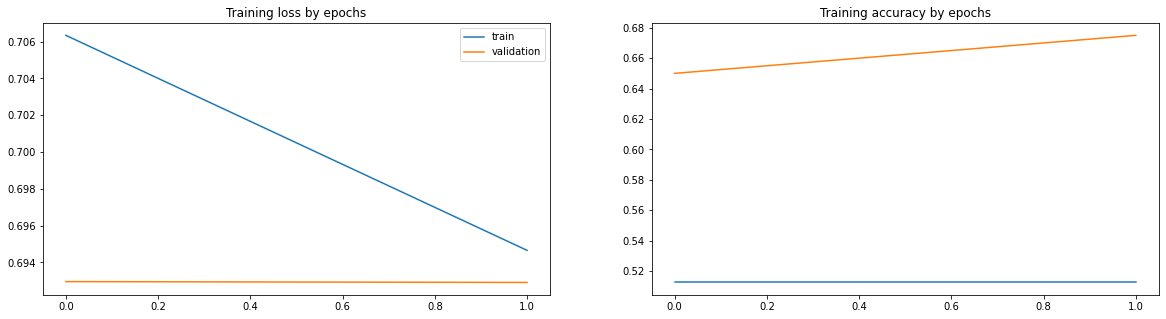

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Training loss by epochs')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.subplot(122)
plt.title('Training accuracy by epochs')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend
plt.show()

In [53]:
!ls -la checkpoints

total 5520
drwxr-xr-x 2 root root    4096 Jun  7 16:55 .
drwxr-xr-x 1 root root    4096 Jun  7 16:55 ..
-rw-r--r-- 1 root root 2819896 Jun  7 16:55 model.01-0.65.h5
-rw-r--r-- 1 root root 2819896 Jun  7 16:55 model.02-0.68.h5


In [55]:
loaded_model = get_model()
loaded_model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])
loaded_model.load_weights('/content/checkpoints/model.02-0.68.h5')
res = loaded_model.evaluate(test_dataset)


7/7 [==============================] - 204s 2s/step - loss: 0.6938 - accuracy: 0.4563


In [56]:
res_furniture = loaded_model.evaluate(test_furniture_dataset)

7/7 [==============================] - 205s 2s/step - loss: 0.6929 - accuracy: 0.5813


In [57]:
print('test accuracy:', res[1], '\n', 'test furniture accuracy:', res_furniture[1])

test accuracy: 0.45625001192092896 
 test furniture accuracy: 0.581250011920929
